In [28]:
import numpy as np
import matplotlib.pyplot as plt
from inktime import rgbkm
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
import cv2
from skimage import io, color

from sklearn.cluster import DBSCAN


## Functions from notebook 07

In [5]:
def preprocessing(img, clip_lim = 1.8, sigma_c = 22, sigma_s = 8, d =10):
    """Increases contrast using CLAHE and removes noise with bilateralFilter"""

    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    L, a, b = cv2.split(lab)
    
    # Apply CLAHE to L channel: brighten L channel
    clahe = cv2.createCLAHE(clipLimit=clip_lim, tileGridSize=(8,8))
    L_enhanced = clahe.apply(L)
    
    # Bilateral filtering on L channel
    L_filtered = cv2.bilateralFilter(
        L_enhanced,
        d= d,               # neighborhood diameter
        sigmaColor=sigma_c,     # range sigma (intensity)
        sigmaSpace=sigma_s       # spatial sigma
    )
    
    # Recombine
    lab_filtered = cv2.merge((L_filtered, a, b))
    result = cv2.cvtColor(lab_filtered, cv2.COLOR_LAB2BGR)
    
    return result

def edge_detection(img, sigma= 2.2, lower = 1e-6, upper = 0.3):
    """" Performs Canny edge detection on image:
    Input:
    - image: uint8 image type
    - sigma: standard deviation gaussian blurr
    - lower and upper: fractions of img.max that form the lower and upper threshold for Canny

    Output:
    - edges_closed: binary images of edges
    """
    
    # Gaussian blurr
    blur = cv2.GaussianBlur(img, (0, 0), sigma).astype(np.uint8)

    # Canny edge detection
    canny_edges = cv2.Canny(blur, lower*img.max(), upper*img.max(), L2gradient=True) 
    
    # Close edges
    kernel = np.ones((3,3), np.uint8)
    edges_closed = cv2.morphologyEx(canny_edges, cv2.MORPH_CLOSE, kernel, iterations=1) 

    return edges_closed

def smooth_edges(edges, min_area = 50, gap_threshold = 70, epsilon = 0.9):
    """" Ensures closed and smoothened edges:
    Input:
    - edges: binary image containing unprocessed canny edges
    - min_area: minimal allowed area of a contour 
    - gap_threshold: maximal distance between starting and ending point of a contour for which the contour is closed
    - epsilon: smoothing parameter being the maximal allowed distance between the original edge and smoothed edge
    
    Output:
    - edges_final: binary image of improved edges
    - smoothed_contours: list of improved contours
    """

    # Find contours
    contours_tuple, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    contours = list(contours_tuple)
    
    smoothed_contours = []
    
    for cnt in contours:
        # Close small gaps if contour is almost closed
        start = cnt[0][0]
        end = cnt[-1][0]
        
        if np.linalg.norm(start - end) < gap_threshold:
            start_reshaped = start.reshape(1,1,2)
            cnt_closed = np.vstack([cnt, start_reshaped])
        else:
            cnt_closed = cnt  # contour remains as is
    
        # Smooth contour using polynomal fitting
        cnt_smooth = cv2.approxPolyDP(cnt_closed, epsilon, False)
    
        # Compute area after closing
        area = cv2.contourArea(cnt_smooth)
        if area < min_area:
            continue  # skip small regions         
        smoothed_contours.append(cnt_smooth) 
        
    print('Number of contours:', len(smoothed_contours))

    # Convert contours back to edges
    edges_smooth = np.zeros_like(edges)
    for cnt in smoothed_contours:
        cv2.drawContours(edges_smooth, [cnt], -1, color=255, thickness=2)

    # Closing again just because
    kernel = np.ones((3,3), np.uint8)
    edges_final = cv2.morphologyEx(edges_smooth, cv2.MORPH_CLOSE, kernel, iterations=1) # closes edges

    return edges_final, smoothed_contours

def labeling(edges):
    free_space = (edges == 0).astype(np.uint8)
    num_labels, labels = cv2.connectedComponents(free_space, connectivity=8)
    H, W = labels.shape
    return labels


def median_color_image(labels, img):
    """
    Compute a median-color for each labeled region.

    Input:
        labels : 2D label image (0 = background)
        img    : original BGR image

    Output:
        median_color_img : BGR image with each region filled by its median color
        median_colors    : (num_labels, 3) array of median LAB colors ordered as np.unique(labels)
    """

    # Convert to lab
    img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

    # Flatten image
    H, W = labels.shape
    labels_flat = labels.ravel()
    img_flat = img_lab.reshape(-1, 3)

    # Obtain number of unique labels
    unique_labels = np.unique(labels_flat)
    num_labels = unique_labels.size

    median_colors = np.zeros((num_labels, 3), dtype=np.float32)

    # Compute medians per region 
    for i, lab_val in enumerate(unique_labels):
        region_pixels = img_flat[labels_flat == lab_val]
        if region_pixels.size > 0:
            median_colors[i] = np.median(region_pixels, axis=0)

    # Create lookup table from label value -> color
    lookup = np.zeros((labels.max() + 1, 3), dtype=np.uint8)
    lookup[unique_labels] = median_colors.astype(np.uint8)

    # Fill each region in the image with its median value 
    median_lab = lookup[labels]

    median_color_img = cv2.cvtColor(median_lab, cv2.COLOR_LAB2BGR)

    return median_color_img, median_colors

def cluster_labels(labels, median_colors, eps=10, min_samples=1):
    """
    Cluster labeled regions by their median LAB color using DBSCAN.

    Parameters:
        labels        : 2D label image
        median_colors : (num_labels, 3) array of median LAB colors
                        (must match order of unique label values)
        eps           : DBSCAN color distance threshold (LAB space)
        min_samples   : DBSCAN min_samples parameter

    Returns:
        clustered_labels : 2D image where each region is replaced by its color-cluster ID
        cluster_ids      : cluster ID per region (aligned with unique_labels)
    """

    # Get unique label values (same order as median_colors)
    unique_labels = np.unique(labels)

    # Run DBSCAN on LAB median colors
    db = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
    cluster_ids = db.fit_predict(median_colors)

    # Map original label values -> cluster IDs
    max_label = labels.max()
    lookup = np.zeros(max_label + 1, dtype=np.int32)

    for i, lab_val in enumerate(unique_labels):
        lookup[lab_val] = cluster_ids[i]

    # Replace labels with cluster IDs
    clustered_labels = lookup[labels]

    return clustered_labels, cluster_ids

def merge_small_color_clusters(labels, clustered_labels, median_colors, min_cluster_area=500):
    """
    Merge small color clusters into nearest larger cluster (LAB space).

    Parameters:
        labels             : original label image
        clustered_labels   : 2D cluster ID image
        median_colors      : (num_regions, 3) LAB medians (aligned with unique labels)
        min_cluster_area   : minimum total pixel area for cluster to survive

    Returns:
        refined_clusters   : updated 2D cluster label image
    """

    refined = clustered_labels.copy()

    # Compute cluster pixel counts
    cluster_ids, counts = np.unique(refined, return_counts=True)

    # Remove noise if exists (0 index contains outliers)
    valid = cluster_ids >= 0
    cluster_ids = cluster_ids[valid]
    counts = counts[valid]

    # Split large vs small
    large_clusters = cluster_ids[counts >= min_cluster_area]
    small_clusters = cluster_ids[counts < min_cluster_area]

    if len(small_clusters) == 0:
        return refined

    # Compute LAB centroid per cluster 
    unique_labels = np.unique(labels)

    cluster_color_centroids = {}

    for cid in cluster_ids:
        region_indices = np.where(refined.ravel() == cid)[0]
        if len(region_indices) == 0:
            continue

        # get corresponding region IDs
        region_labels = labels.ravel()[region_indices]
        region_labels_unique = np.unique(region_labels)

        # map region label -> index in median_colors
        region_idx = np.searchsorted(unique_labels, region_labels_unique)
        cluster_color_centroids[cid] = np.mean(median_colors[region_idx], axis=0)

    # Reassign small clusters 
    for sc in small_clusters:

        sc_color = cluster_color_centroids[sc]

        # compute distances to large clusters
        distances = []
        for lc in large_clusters:
            lc_color = cluster_color_centroids[lc]
            d = np.linalg.norm(sc_color - lc_color)
            distances.append((d, lc))

        if len(distances) == 0:
            continue

        _, nearest_cluster = min(distances, key=lambda x: x[0])

        # reassign pixels
        refined[refined == sc] = nearest_cluster

    return refined

## Extracting masks

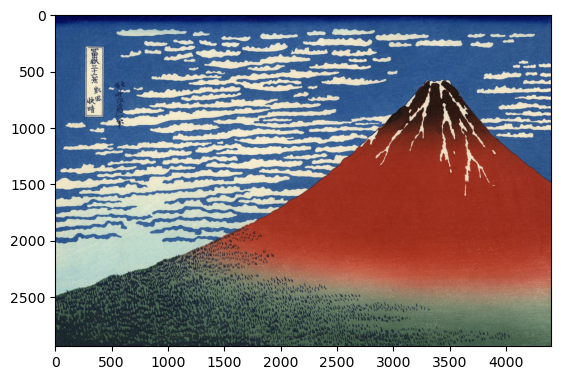

In [8]:
img = cv2.imread('red_fuji3.jpg') # high res
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
height, width, _ = img.shape

plt.imshow(img)
plt.show()

In [10]:
processed_img = preprocessing(img)
edges = edge_detection(processed_img)
edges, _ = smooth_edges(edges)

labels = labeling(edges)
med_color_img, median_colors = median_color_image(labels, img)
clustered_labels, cluster_ids = cluster_labels(labels, median_colors)
labels = merge_small_color_clusters(labels, clustered_labels, median_colors)


Number of contours: 2882


Number of regions after merging: 4


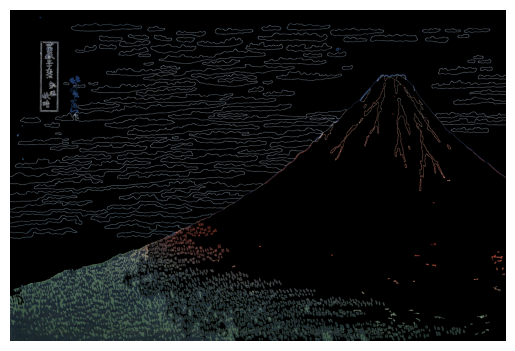

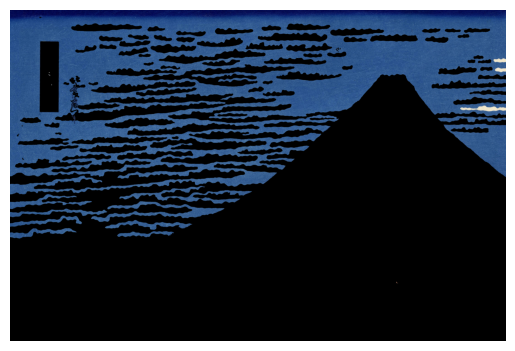

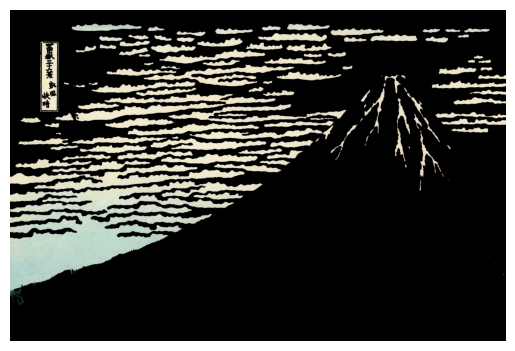

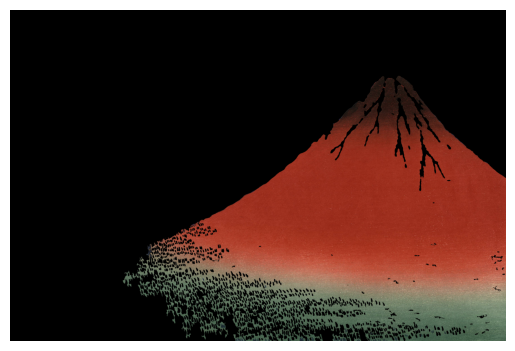

In [12]:
cluster_ids = np.unique(labels)
print('Number of regions after merging:', len(cluster_ids))

for cid in cluster_ids:
    mask = (labels == cid)

    plt.imshow(img * mask[:,:,None])
    plt.axis('off')
    plt.show()

## Extracting gradients

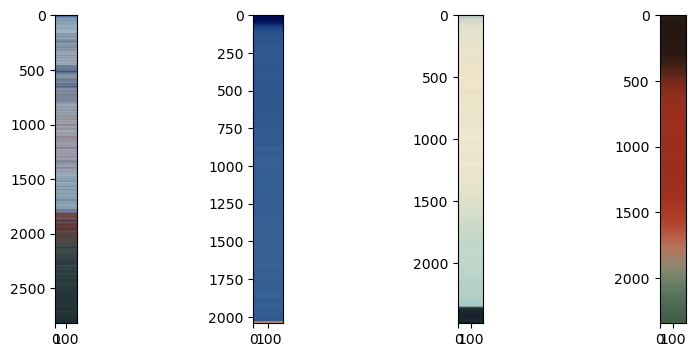

In [15]:
gradients = []

fig, ax = plt.subplots(1,4, figsize = (10,4))
for i, cid in enumerate(cluster_ids):
    grad = []
    mask = (labels == cid)
    for y in range(height):
        row_mask = mask[y]
        if row_mask.any():
            grad.append(np.median(img[y, row_mask], axis=0))

    grad = np.array(grad) # grad: (N, 3)
    grad = grad.astype('uint8')
    gradients.append(grad)
    
    ax[i].imshow(np.repeat(grad[:,None,:], 200, axis=1))

plt.show()

## Histogram 

In [24]:
def lab_histogram(img, bins=32):
    lab_img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    lab = img.reshape(-1,3)
    hist, edges = np.histogramdd(lab, bins=(bins,bins,bins), range=((0,100),(-128,127),(-128,127)))
    return hist, edges

def smooth_histogram(hist, sigma=1):
    return gaussian_filter(hist, sigma=sigma)

def plot_lab_histogram(hist, edges, alpha=0.8, min_counts = 5):
     # 3D scatter plot of RGB histogram bin centers

    # Centers of bins
    centers = [0.5 * (e[:-1] + e[1:]) for e in edges]
    L, A, B = np.meshgrid(*centers, indexing='ij')

    pts = np.column_stack([L.ravel(), A.ravel(), B.ravel()])
    counts = hist.ravel()

    mask = counts >= min_counts

    pts = pts[mask]
    counts = counts[mask]
    
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')

    s = 5 + np.sqrt(counts)

    ax.scatter( pts[:,0], pts[:,1], pts[:,2], c=pts, s=s, alpha=alpha )
    ax.set_xlabel("L")
    ax.set_ylabel("A")
    ax.set_zlabel("B")

    return fig, ax

ValueError: RGBA values should be within 0-1 range

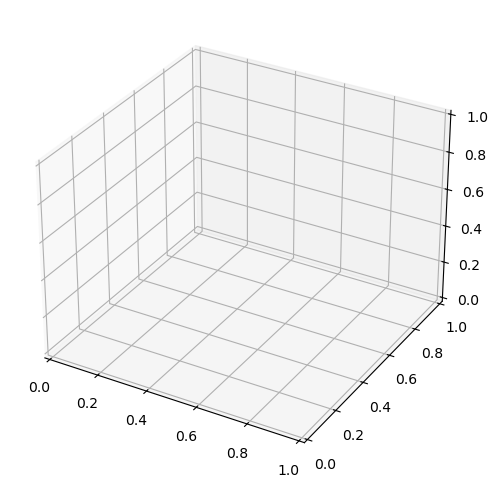

In [26]:
hist, edges = lab_histogram(img)
fig, ax = plot_lab_histogram(hist, edges)
plt.show()

#
#rgb = io.imread(filename)
#lab = color.rgb2lab(rgb)